In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import tensorflow as tf
from alphazero.coach import Coach
from alphazero.gomoku_game import GomokuGame as Game
from alphazero.interfaces import TrainParams
from domoku.policies.maximal_criticality import MaxCriticalityPolicy
from domoku.policies.softadvice import MaxInfluencePolicy, MaxInfluencePolicyParams
from domoku.policies import softadvice
from domoku.constants import *

In [3]:
BOARD_SIZE = 15

In [4]:
def given_heuristic_brain():
    hard_policy = MaxCriticalityPolicy(board_size=BOARD_SIZE, overconfidence=5.0)
    params = MaxInfluencePolicyParams(
        board_size=BOARD_SIZE,
        sigma=.6,
        iota=6,
        radial_constr=[.0625, .125, .25, .5],
        radial_obstr=[-.0625, -.125, -.25, -.5]
    )
    policy = MaxInfluencePolicy(params, criticality_model=hard_policy, pov=BLACK)
    return softadvice.NeuralNetAdapter(policy)

In [6]:
params = TrainParams(
    epochs_per_train=1,
    update_threshold=0.6,
    max_queue_length=200000,    # Number of game examples to train the neural networks.
    num_simulations=25,
    arena_compare=40,         # Number of games to play during arena play to evaluate new network.
    cpuct=1.0,
    checkpoint_dir='./temperature/',
    load_model=False,
    load_folder_file=('/dev/models/8x100x50', 'best.pth.tar'),
    num_iters_for_train_examples_history=2,
    num_iterations=2,
    num_episodes=2,
    temperature_threshold=3
)

brain = given_heuristic_brain()

detector = MaxCriticalityPolicy(BOARD_SIZE)

game = Game(15, detector=detector, initial='H8', model=brain)

game.get_initial_board()

coach = Coach(game, brain, brain, params=params)

2022-06-13 18:34:49.193717: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/wgiersche/.local/share/virtualenvs/DeepGomoku-cXtJ_EtM/lib/python3.10/site-packages/numpy/core/fromnumeric.py:2007: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


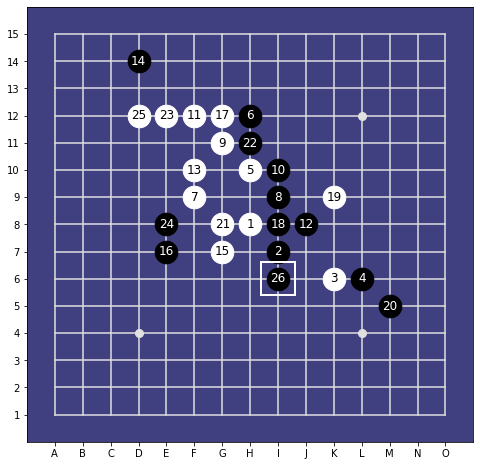

In [10]:
from alphazero.mcts import MCTS

defender = MCTS(game, brain, params)
train_examples = coach.execute_episode(defender)
len(train_examples)
stones = coach.recover_moves(train_examples)
from domoku.board import GomokuBoard as LegacyBoard
board = LegacyBoard(n=BOARD_SIZE, disp_width=8, stones=[stone.xy() for stone in stones])
board.display()

---

# The model

In [11]:
from alphazero.gomoku_model import NeuralNetAdapter

In [12]:
network = NeuralNetAdapter(input_size=17)
print(f"Model class: {type(network.policy)}\n")
network.policy.summary()

Model class: <class 'alphazero.gomoku_model.GomokuModel'>

Model: "gomoku_model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          multiple                  11648     
                                                                 
 Potential_0 (Conv2D)        multiple                  123936    
                                                                 
 Potential_1 (Conv2D)        multiple                  123936    
                                                                 
 Potential_2 (Conv2D)        multiple                  123936    
                                                                 
 Potential_3 (Conv2D)        multiple                  123936    
                                                                 
 Potential_4 (Conv2D)        multiple                  123936    
                                                           

In [13]:
network.train(train_examples, params=params)

Training: 100%|██████████| 1/1 [00:01<00:00,  1.52s/it]

Epochs: 1, Loss: 7.395979881286621


In [10]:
defender = MCTS(game, brain, params)
challenger = MCTS(game, network, params)

In [11]:
params = TrainParams(
    epochs_per_train=10,
    update_threshold=0.6,
    max_queue_length=20,    # Number of game examples to train the neural networks.
    num_simulations=25,
    arena_compare=2,         # Number of games to play during arena play to evaluate new network.
    cpuct=1.0,
    checkpoint_dir='./temperature/',
    load_model=False,
    load_folder_file=('/dev/models/8x100x50', 'best.pth.tar'),
    num_iters_for_train_examples_history=4,
    num_iterations=2,
    num_episodes=4,
    temperature_threshold=6
)
coach = Coach(game, brain.policy, challenger=network, params=params)

In [12]:
coach.train(defender, challenger)

[autoreload of alphazero.interfaces failed: Traceback (most recent call last):
  File "/Users/wgiersche/.local/share/virtualenvs/DeepGomoku-cXtJ_EtM/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 257, in check
    superreload(m, reload, self.old_objects)
  File "/Users/wgiersche/.local/share/virtualenvs/DeepGomoku-cXtJ_EtM/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 480, in superreload
    update_generic(old_obj, new_obj)
  File "/Users/wgiersche/.local/share/virtualenvs/DeepGomoku-cXtJ_EtM/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 377, in update_generic
    update(a, b)
  File "/Users/wgiersche/.local/share/virtualenvs/DeepGomoku-cXtJ_EtM/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 345, in update_class
    update_instances(old, new)
  File "/Users/wgiersche/.local/share/virtualenvs/DeepGomoku-cXtJ_EtM/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 303, in update_ins